<a href="https://colab.research.google.com/github/jangjung-coding/studyBook_practical_statics_for_datascientist/blob/main/Chapter1_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

본 노트북은 'Practical Statistisc for Data Scientist'의 책 중 1장을 공부한 내용을 담고 있다.

**용어 정리**
- 수치형: 숫자를 이용해 표현할 수 있는 데이터
- 연속형: 일정 범위 안에서 어떤 값이든 취할 수 있는 데이터(유의어: 구간형, 실수형, 수치형 데이터)
- 이산: 횟수와 같은 정수 값만 취할 수 있는 데이터(유의어: 정수형, 회수 데이터)
- 범주형: 가능한 범주 안의 값만을 취하는 데이터(유의어: 목록, 열거, 요인, 명목, 다항)
- 이진: 두개의 값(0/1)만을 갖는 범주형 데이터의 특수한 경우(유의어: 이향적, 논리형, 지표, 불리언 데이터)
- 순서형: 값들 사이에 분명한 순위가 있는 범주형 데이터(유의어: 정렬된 요인 데이터, 서수형)

In [ ]:
!pip install wquantiles

In [ ]:
# Import required Python packages
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles # 가중치가 있는 데이터의 분위수 계산

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
try:
    import common  # common 모듈을 임포트 시도
    Data = common.dataDirectory()  # common 모듈의 dataDirectory 함수를 호출하여 Data 변수에 할당
except ImportError:  # 만약 common 모듈이 없을 경우
    from pathlib import Path  # pathlib 모듈에서 Path 클래스를 임포트
    Data = Path().resolve() / 'data'  # 현재 디렉토리의 'data' 폴더 경로를 Data 변수에 할당

In [ ]:
AIRLINE_STATS_CSV = Data / 'airline_stats.csv'
KC_TAX_CSV = Data / 'kc_tax.csv.gz'
LC_LOANS_CSV = Data / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = Data / 'dfw_airline.csv'
SP500_Data_CSV = Data / 'sp500_DATA.csv.gz'
SP500_SECTORS_CSV = Data / 'sp500_sectors.csv'
STATE_CSV = Data / 'state.csv'

### Example: Location Esimates of Poulation and Murder Rates

In [ ]:
state = pd.read_csv(STATE_CSV)
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


In [ ]:
print(state['Population'].mean())
print(state['Population'].median())
print(trim_mean(state['Population'], 0.1)) # 절사평균(trim=0.1은 각 끝에서 10%를 제외한다)

6162876.3
4436369.5
4783697.125


In [ ]:
print(state['Murder.Rate'].mean())

4.066


In [ ]:
print(np.average(state['Murder.Rate'], weights=state['Population'])) # 가중평균

4.445833981123393


**위치 추정**
- 가장 기본적인 위치 추정 기법은 평균이다. 하지만 극단값(특잇값)에 민감할 수 있다.
- 중간값, 절사평균과 같은 다른 방법들이 특잇값이나 이상 데이터에 덜 민감하므로 좀 더 로버스트하다.

**자유도 n 아니면 n-1?**

분산 수식에 n을 분모로 사용한다면, 모집단의 분산과 표준편차의 참값을 과소평가하게 된다. 이를 편향이라 한다. 하지만, 만약 n대신 n-1로 나눈다면, 이 분산은 비편향 추정이 된다. 왜 n을 사용하는게 편향 주청이 되는지를 설명하려면, 추정값을 계산할 때 제약 조건의 개수를 의미하는 자유도에 대해 알아야 한다. 이 경우, 표준편차는 표본의 평균에 따른다는 하나의 제약 조건을 가지고 있기 때문에 n-1의 자유도를 갖는다. 대부분의 경우 데이터 과학자들은 자유도에 크게 신경 쓰지 않아도 되지만 때로 이 개념이 중요할 때도 있다.

In [ ]:
print(state['Population'].std()) # 표준편차

6848235.347401142


In [ ]:
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25)) # 사분위 범위 IQR

4847308.0


In [ ]:
print(robust.scale.mad(state['Population'])) # 절대중위 편차 MAD
print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)

3849876.1459979336
3849876.1459979336


**변이 추정**

- 분산과 표준편차는 가장 보편적으로 널리 사용되는 변이 측정 방법이다. 이들 모두 특잇값에 민감하다.
- 중간값과 백분위수(분위수)로부터 평균절대편차와 중간값의 중위절대편차를 구하는 것이 좀 더 로버스트하다.

In [36]:
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [37]:
percentates = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state['Murder.Rate'].quantile(percentates))
df.index = [f'{p*100}%' for p in percentates]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


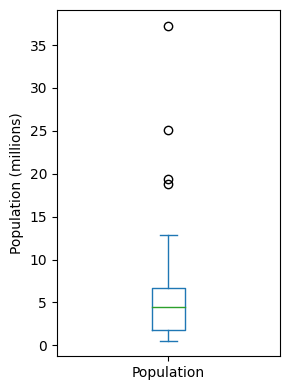

In [42]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3,4)) # 꿀팁!!
ax.set_ylabel("Population (millions)")

plt.tight_layout()
plt.show()